Assignment 3 : Classification Finale
===
##Hector Curi - Spencer Kaiser

---
Instructions
---
You are to build upon the predictive analysis (classification) that you already completed in assignment two, adding additional modeling from new classification algorithms. You should use appropriate cross validation for all of your analysis (you should exlpain your chosen method of validation). Try to use as much testing data as possible in a realistic manner (you should define what you think is realistic and why). Follow the CRISP-DM framework in your analysis (you are not performing all of the CRISP-DM outline, only the portions relevant to the grading rubric outlined below). This report is worth 20% of the final grade. You may complete this assignment in teams of as many as three people (but no more). Only turn in one report to blackboard. 

Write a report covering all the steps of the project. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.

---
Dataset Selection
---
Select a dataset identically to the way you selected for assignment one. You are not required to use the same dataset that you used for assignment one or assignment two, but you are encouraged. You must identify two or more classification OR regression tasks from the dataset. For example, if your dataset was from the diabetes data you might try to predict two tasks: (1) if a patient will be readmitted within a 30 day period or not, and (2) what the total number of days a patient will spend in the hospital, given their history and specifics of the encounter. 

---
### Choice of Classification Tasks
We want to predict the following:
1. Predict if a person makes **more than $50,000 dollars a year**, based on their age, race, sex, etc. (all of the attributes)
2. Predict if a person makes **capital trades**, based on their age, race, sex, etc. (all of the attributes)
---
### Initial Code


In [73]:
#import all packages used in this assignment
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from pandas.tools.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from numpy import random as rd
from sklearn import metrics as mt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

# read in the csv file
df_raw = pd.read_csv('data/adult.data')

Data Preparation
---

---
### 1. Class Variables (10 points)
**Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis**

In [74]:
# Here is the general description of our data
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 4.0+ MB


In [75]:
# As we can see, it seems that all of the values are there, but after looking at the actual data file
# we noticed that there are some values recorded as '?', these are the missing values.

# First let's replace ' ?' with NaN (not a number) for all the missing values
df = df_raw.replace(to_replace='?',value=np.nan)

# Now let's see how many values we actually have
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    31978 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 4.0+ MB


In [76]:
# We can see that workclass, occupation and native-country have some missing values.
# Because only 2399 rows have missing values in them out of 32561 total (7.36% of the data),
# We will just remove those instances from our dataset.

df = df.dropna(how='any')

# Now the data has 30162 instances with no missing values. :)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 15 columns):
age               30162 non-null int64
workclass         30162 non-null object
fnlwgt            30162 non-null int64
education         30162 non-null object
education-num     30162 non-null int64
marital-status    30162 non-null object
occupation        30162 non-null object
relationship      30162 non-null object
race              30162 non-null object
sex               30162 non-null object
capital-gain      30162 non-null int64
capital-loss      30162 non-null int64
hours-per-week    30162 non-null int64
native-country    30162 non-null object
income            30162 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [77]:
# Now we are going to remove the attributes that we think are not useful for our model
# fnlwgt is an assigned weight by the census bureau, we don't know it's formula so its useless to us
del df['fnlwgt']

# education-num is an ordinal representation of the education level, which is better for data modelling
# thus we remove the education attribute
del df['education']

# relationship contains very strange values such as "Not-in-family, Other-relative, Own-child", so we will get rid of it.
del df['relationship']

In [78]:
# Now our data contains these attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 12 columns):
age               30162 non-null int64
workclass         30162 non-null object
education-num     30162 non-null int64
marital-status    30162 non-null object
occupation        30162 non-null object
race              30162 non-null object
sex               30162 non-null object
capital-gain      30162 non-null int64
capital-loss      30162 non-null int64
hours-per-week    30162 non-null int64
native-country    30162 non-null object
income            30162 non-null object
dtypes: int64(5), object(7)
memory usage: 3.0+ MB


In [79]:
# Now we are going to rename the attributes for an easier understanding of the data
df = df.rename(columns={'income': 'salaryOver50K', 'sex': 'isMale', 'education-num':'educationLevel',
                        'marital-status':'maritalStatus','capital-gain':'capitalGain','capital-loss':'capitalLoss',
                        'native-country':'nativeCountry','hours-per-week':'hoursPerWeek'})

In [80]:
# Now our data contains these attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 12 columns):
age               30162 non-null int64
workclass         30162 non-null object
educationLevel    30162 non-null int64
maritalStatus     30162 non-null object
occupation        30162 non-null object
race              30162 non-null object
isMale            30162 non-null object
capitalGain       30162 non-null int64
capitalLoss       30162 non-null int64
hoursPerWeek      30162 non-null int64
nativeCountry     30162 non-null object
salaryOver50K     30162 non-null object
dtypes: int64(5), object(7)
memory usage: 3.0+ MB


In [81]:
# Now let's convert to camel case all of the values with dashes in workclass
df = df.replace(to_replace='Federal-gov',value='FederalGovernment')
df = df.replace(to_replace='State-gov',value='StateGovernment')
df = df.replace(to_replace='Never-worked',value='NeverWorked')
df = df.replace(to_replace='Private',value='Private')
df = df.replace(to_replace='Self-emp-inc',value='SelfEmployedIncorporated')
df = df.replace(to_replace='Self-emp-not-inc',value='SelfEmpoyedNotIncorporated')
df = df.replace(to_replace='Local-gov',value='LocalGovernment')
df = df.replace(to_replace='Without-pay',value='WithoutPay')

# Now let's convert to camel case all of the values with dashes in marital status
df = df.replace(to_replace='Married-AF-spouse',value='MarriedAFSpouse')
df = df.replace(to_replace='Married-civ-spouse',value='MarriedCivSpouse')
df = df.replace(to_replace='Married-spouse-absent',value='MarriedSpouseAbsent')
df = df.replace(to_replace='Never-married',value='NeverMarried')

# Now let's convert to camel case all of the values with dashes in occupation
df = df.replace(to_replace='Adm-clerical',value='AdmClerical')
df = df.replace(to_replace='Armed-Forces,',value='ArmedForces,')
df = df.replace(to_replace='Craft-repair',value='CraftRepair')
df = df.replace(to_replace='Exec-managerial',value='ExecManagerial')
df = df.replace(to_replace='Farming-fishing',value='FarmingFishing')
df = df.replace(to_replace='Handlers-cleaners',value='HandlersCleaners')
df = df.replace(to_replace='Machine-op-inspct',value='MachineOpsInspector')
df = df.replace(to_replace='Other-service',value='OtherService')
df = df.replace(to_replace='Priv-house-serv',value='PrivHouseServ')
df = df.replace(to_replace='Prof-specialty',value='ProfSpecialty')
df = df.replace(to_replace='Protective-serv',value='ProtectiveServant')
df = df.replace(to_replace='Tech-support',value='TechSupport')
df = df.replace(to_replace='Transport-moving',value='TransportMoving')

# Now let's convert to camel case all of the values with dashes in race
df = df.replace(to_replace='Amer-Indian-Eskimo',value='AmerIndianEskimo')
df = df.replace(to_replace='Asian-Pac-Islander',value='AsianPacIslander')

# Now let's convert to camel case all of the values with dashes in nativeCountry
df = df.replace(to_replace='Dominican-Republic',value='DominicanRepublic,')
df = df.replace(to_replace='El-Salvador',value='ElSalvador,')
df = df.replace(to_replace='Holand-Netherlands',value='Netherlands')
df = df.replace(to_replace='Outlying-US(Guam-USVI-etc)',value='OutlyingUS')
df = df.replace(to_replace='Puerto-Rico',value='PuertoRico')
df = df.replace(to_replace='Trinadad&Tobago',value='Trinidad&Tobago')
df = df.replace(to_replace='United-States',value='US')

In [82]:
# Now our data looks like this
df.head()

,age,workclass,educationLevel,maritalStatus,occupation,race,isMale,capitalGain,capitalLoss,hoursPerWeek,nativeCountry,salaryOver50K
0,39,StateGovernment,13,NeverMarried,AdmClerical,White,Male,2174,0,40,US,<=50K
1,50,SelfEmpoyedNotIncorporated,13,MarriedCivSpouse,ExecManagerial,White,Male,0,0,13,US,<=50K
2,38,Private,9,Divorced,HandlersCleaners,White,Male,0,0,40,US,<=50K
3,53,Private,7,MarriedCivSpouse,HandlersCleaners,Black,Male,0,0,40,US,<=50K
4,28,Private,13,MarriedCivSpouse,ProfSpecialty,Black,Female,0,0,40,Cuba,<=50K


In [83]:
# Now let's replace the binomial attributes with binary values 1 and 0
# replace sex values with binary values
df = df.replace(to_replace='Female',value=0)
df = df.replace(to_replace='Male',value=1)

# replace income values with binary values
df = df.replace(to_replace='<=50K',value=0)
df = df.replace(to_replace='>50K',value=1)

In [84]:
# Now our data looks like this
df.head()

,age,workclass,educationLevel,maritalStatus,occupation,race,isMale,capitalGain,capitalLoss,hoursPerWeek,nativeCountry,salaryOver50K
0,39,StateGovernment,13,NeverMarried,AdmClerical,White,1,2174,0,40,US,0
1,50,SelfEmpoyedNotIncorporated,13,MarriedCivSpouse,ExecManagerial,White,1,0,0,13,US,0
2,38,Private,9,Divorced,HandlersCleaners,White,1,0,0,40,US,0
3,53,Private,7,MarriedCivSpouse,HandlersCleaners,Black,1,0,0,40,US,0
4,28,Private,13,MarriedCivSpouse,ProfSpecialty,Black,0,0,0,40,Cuba,0


In [85]:
# Now let's rearrange the columns
df = df[['isMale','age','race','nativeCountry','maritalStatus',
         'educationLevel','workclass','occupation','hoursPerWeek',
         'capitalGain','capitalLoss','salaryOver50K']]
df.head()

,isMale,age,race,nativeCountry,maritalStatus,educationLevel,workclass,occupation,hoursPerWeek,capitalGain,capitalLoss,salaryOver50K
0,1,39,White,US,NeverMarried,13,StateGovernment,AdmClerical,40,2174,0,0
1,1,50,White,US,MarriedCivSpouse,13,SelfEmpoyedNotIncorporated,ExecManagerial,13,0,0,0
2,1,38,White,US,Divorced,9,Private,HandlersCleaners,40,0,0,0
3,1,53,Black,US,MarriedCivSpouse,7,Private,HandlersCleaners,40,0,0,0
4,0,28,Black,Cuba,MarriedCivSpouse,13,Private,ProfSpecialty,40,0,0,0


In [86]:
# We can also group by age range like this
df['ageRange'] = pd.cut(df.age,[16,20,30,40,50,60,70,80,91],8,
                         labels=['17-20','20s','30s','40s','50s','60s','70s','80s',])

In [87]:
# And by hours-per-week
df['hourRange'] = pd.cut(df['hoursPerWeek'], [0,21,41,61,81,100], 5, labels=['1-20', '21-40', '41-60','61-80','80-99'])

In [88]:
# For capital gain and capital loss, based on the fact that someone with a capital gain
# can't have a capital loss, and viceversa, we will combine the attributes into one
# then we will store as a boolean of wheter they make capital transactions or not
# most people in the dataset have a value of 0 in both, so it is more useful to know 
# wheter they invest in capital or not, as opposed to how much they do it
df['hasCapitalTransactions'] = ((df.capitalGain - df.capitalLoss)!=0).astype(np.int)

In [89]:
df.head()

,isMale,age,race,nativeCountry,maritalStatus,educationLevel,workclass,occupation,hoursPerWeek,capitalGain,capitalLoss,salaryOver50K,ageRange,hourRange,hasCapitalTransactions
0,1,39,White,US,NeverMarried,13,StateGovernment,AdmClerical,40,2174,0,0,30s,21-40,1
1,1,50,White,US,MarriedCivSpouse,13,SelfEmpoyedNotIncorporated,ExecManagerial,13,0,0,0,40s,1-20,0
2,1,38,White,US,Divorced,9,Private,HandlersCleaners,40,0,0,0,30s,21-40,0
3,1,53,Black,US,MarriedCivSpouse,7,Private,HandlersCleaners,40,0,0,0,50s,21-40,0
4,0,28,Black,Cuba,MarriedCivSpouse,13,Private,ProfSpecialty,40,0,0,0,20s,21-40,0


In [90]:
# For origin, since 97% of the people are from the US, we will change it to a boolean that
# represents if you are from foreign origin (1) or domestic (0)
df['isForeign'] = (df.nativeCountry!="US").astype(np.int)

In [91]:
df.head()

,isMale,age,race,nativeCountry,maritalStatus,educationLevel,workclass,occupation,hoursPerWeek,capitalGain,capitalLoss,salaryOver50K,ageRange,hourRange,hasCapitalTransactions,isForeign
0,1,39,White,US,NeverMarried,13,StateGovernment,AdmClerical,40,2174,0,0,30s,21-40,1,0
1,1,50,White,US,MarriedCivSpouse,13,SelfEmpoyedNotIncorporated,ExecManagerial,13,0,0,0,40s,1-20,0,0
2,1,38,White,US,Divorced,9,Private,HandlersCleaners,40,0,0,0,30s,21-40,0,0
3,1,53,Black,US,MarriedCivSpouse,7,Private,HandlersCleaners,40,0,0,0,50s,21-40,0,0
4,0,28,Black,Cuba,MarriedCivSpouse,13,Private,ProfSpecialty,40,0,0,0,20s,21-40,0,1


In [92]:
# Also here are the data types of our attributes, as we can see isMale and salaryOver50K are already integers
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 16 columns):
isMale                    30162 non-null int64
age                       30162 non-null int64
race                      30162 non-null object
nativeCountry             30162 non-null object
maritalStatus             30162 non-null object
educationLevel            30162 non-null int64
workclass                 30162 non-null object
occupation                30162 non-null object
hoursPerWeek              30162 non-null int64
capitalGain               30162 non-null int64
capitalLoss               30162 non-null int64
salaryOver50K             30162 non-null int64
ageRange                  30162 non-null category
hourRange                 30162 non-null category
hasCapitalTransactions    30162 non-null int64
isForeign                 30162 non-null int64
dtypes: category(2), int64(9), object(5)
memory usage: 3.5+ MB


In [93]:
# Now we will make all the categorical (object) attributes into one-hot encoded values
# Also store current dataframe just in case
dfClean = df.copy(deep=True)

# race
tmp_df = pd.get_dummies(df.race,prefix='race')
dfModel = pd.concat((df,tmp_df),axis=1)

# maritalStatus
tmp_df = pd.get_dummies(df.maritalStatus,prefix='marriage')
dfModel = pd.concat((dfModel,tmp_df),axis=1)

# workclass
tmp_df = pd.get_dummies(df.workclass,prefix='workclass')
dfModel = pd.concat((dfModel,tmp_df),axis=1)

# occupation
tmp_df = pd.get_dummies(df.occupation,prefix='occupation')
dfModel = pd.concat((dfModel,tmp_df),axis=1)

# occupation
tmp_df = pd.get_dummies(df.ageRange,prefix='ageRange')
dfModel = pd.concat((dfModel,tmp_df),axis=1)

# occupation
tmp_df = pd.get_dummies(df.hourRange,prefix='hourRange')
dfModel = pd.concat((dfModel,tmp_df),axis=1)

# print data model
df = dfModel
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 62 columns):
isMale                                  30162 non-null int64
age                                     30162 non-null int64
race                                    30162 non-null object
nativeCountry                           30162 non-null object
maritalStatus                           30162 non-null object
educationLevel                          30162 non-null int64
workclass                               30162 non-null object
occupation                              30162 non-null object
hoursPerWeek                            30162 non-null int64
capitalGain                             30162 non-null int64
capitalLoss                             30162 non-null int64
salaryOver50K                           30162 non-null int64
ageRange                                30162 non-null category
hourRange                               30162 non-null category
hasCapitalTransactions    

In [94]:
df.head()

,isMale,age,race,nativeCountry,maritalStatus,educationLevel,workclass,occupation,hoursPerWeek,capitalGain,...,ageRange_40s,ageRange_50s,ageRange_60s,ageRange_70s,ageRange_80s,hourRange_1-20,hourRange_21-40,hourRange_41-60,hourRange_61-80,hourRange_80-99
0,1,39,White,US,NeverMarried,13,StateGovernment,AdmClerical,40,2174,...,0,0,0,0,0,0,1,0,0,0
1,1,50,White,US,MarriedCivSpouse,13,SelfEmpoyedNotIncorporated,ExecManagerial,13,0,...,1,0,0,0,0,1,0,0,0,0
2,1,38,White,US,Divorced,9,Private,HandlersCleaners,40,0,...,0,0,0,0,0,0,1,0,0,0
3,1,53,Black,US,MarriedCivSpouse,7,Private,HandlersCleaners,40,0,...,0,1,0,0,0,0,1,0,0,0
4,0,28,Black,Cuba,MarriedCivSpouse,13,Private,ProfSpecialty,40,0,...,0,0,0,0,0,0,1,0,0,0


In [95]:
# Finally, let's delete the object attributes from our data model
del df['race']
del df['nativeCountry']
del df['maritalStatus']
del df['occupation']
del df['workclass']
del df['capitalGain']
del df['capitalLoss']
del df['age']
del df['hoursPerWeek']
del df['ageRange']
del df['hourRange']

---
### 2. Final Data Set (5 points)
**Describe the final dataset that is used for classification (include a description of any newly formed variables you created).**

In [96]:
# Now our data set looks like this
df.info(20)
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 51 columns):
isMale                                  30162 non-null int64
educationLevel                          30162 non-null int64
salaryOver50K                           30162 non-null int64
hasCapitalTransactions                  30162 non-null int64
isForeign                               30162 non-null int64
race_AmerIndianEskimo                   30162 non-null float64
race_AsianPacIslander                   30162 non-null float64
race_Black                              30162 non-null float64
race_Other                              30162 non-null float64
race_White                              30162 non-null float64
marriage_Divorced                       30162 non-null float64
marriage_MarriedAFSpouse                30162 non-null float64
marriage_MarriedCivSpouse               30162 non-null float64
marriage_MarriedSpouseAbsent            30162 non-null float64
marriage_NeverMarri

,isMale,educationLevel,salaryOver50K,hasCapitalTransactions,isForeign,race_AmerIndianEskimo,race_AsianPacIslander,race_Black,race_Other,race_White,...,ageRange_40s,ageRange_50s,ageRange_60s,ageRange_70s,ageRange_80s,hourRange_1-20,hourRange_21-40,hourRange_41-60,hourRange_61-80,hourRange_80-99
0,1,13,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,1,13,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
2,1,9,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,1,7,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0,13,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


The final data set contains 'complete' instances which have no missing values. This data set is roughly 93% of the original data set and consists of binary and one-hot encoded attributes, with one attribute remaining as ordinal (education). We decided to create a variety of new attributes to better analyze their impact upon the target attribute, 'salaryOver50K'. 

'salaryOver50K' is a binary variable which indicates whether an individual, an instance in the context of the data set, has a salary over $50k. 

Because of the minimal number of instances in which individuals have either capital gains or losses, we decided to create a boolean representation of whether or not the individual has any gains or losses whatsoever. If they do, 'hasCapitalTransactions' is set to a 1.

We did a similar compilation with the nativeCountry attribute, where we realized that 97% of the people in the dataset were from the US and transformed nativeCountry into a boolean attribute (isForeign), that is true if for the few people that are not domestic.

Furthermore, we decided to break up age and salary into categorical, one-hot encoded variables for analysis. Both of the attributes are broken into chunks that adequately break up the data for easy analysis.

Finally, we decided to convert sex to a binary value and to do so, we chose to label the attribute as 'isMale' for readability. This way, the attribute is a binary value, however, the values are still readable to someone viewing the data.

Modeling and Evaluation
---

---
### 1. Evaluation Metrics (10 points)
**Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or a mix of all of them). Why are these appropriate for analyzing the results of your modeling?**

As discussed in our previous lab, the primary use of the data gleaned from this analysis will be for marketing purposes (Classification Task 1). In addition, the analysis of whether an individual makes capital trades (Classificiation Task 2) may be very useful to the IRS for identifying individuals that could potentially attempt to evade their taxes by failing to report their capital earnings.
<br>
<br>
While it may not appear that that these classifications and associated real-world uses have much in common, they have one important commonality: the risk of omitting a potential lead/audit (false negative) greatly outweighs the risk of including an incorrectly classified individual (false positive). 
<br>
<br>
For example, if a marketer were to include someone who does not make a salary of over 50k (false positive) in a promotion targeted at wealthy individuals, it will likely not generate any sales but it will only incur a small cost. On the other hand, if the data does not include an individual that was classified incorrectly (false negative), there is a potential for a significant loss in sales, especially in terms of the promotional campaign as a whole.
<br>
<br>
In order to minimize the amount of false negatives generated by our model, we have decided to use <strong>Recall</strong> as our primary evaluation metric. For the purposes of this assignment, Recall evaluations will be conducted in the context of identifying >50k salaries (<i>i.e., if an individual falls on the border between target classes, classify as >50k</i>) and in the context of identifying individuals who make capital trades. We will also be utilizing <strong>Accuracy</strong> as a form of baseline accuracy and for additional analyses. Finally, we will be calculating <strong>Precision</strong> and <strong>F-Measure</strong> as they may be pertinent for future analysis.
<br>
<br>

---
### 2. Training and Testing Split (10 points)
**Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate.**

We will use <strong>Stratified 10-Fold Cross Validation</strong> for our analysis. Stratified 10-Fold Cross Validation will provide our analysis with a high degree of generalization and refinement, however, it is appropriate for use in our analysis due to one characteristic of our data set:

<ul>
<li>
<strong>Data Consistency (Locality)</strong>: Because the data in our data set was collected from across the United States and because it includes such a diverse sample of individuals, it is very likely that the features that are highly correlated to our target classes will be indicators of that target class <i>regardless</i> of the location from which the data was obtained. In other words, the locality of our testing data should not influence the classification of independent testing data. This is very important for future analysis using the model we create; if this model is tested against data from a specific locale in the future, under the assumption stated above, the model should still maintain a similar level of accuracy to that of the analysis of the entire data set as a whole. As a result, the number of instances per fold will not have any significant impact upon our analysis.
</li>
</ul>
<br>
Stratified 10-Fold Cross Validation will provide us with a thorough method of splitting, training, and testing our models against our data set.

---
### 3. Classification Models (20 points)
**Create three different classification/regression models (e.g., random forest, KNN, and SVM). Two modeling techniques must be new (but the thrid could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance.**

First, let's make a copy of our final data set, just in case. 

In [97]:
dfFinal = df.copy(deep=True)

### Classification Task 1
Predict if a person makes more than 50, 000 dollars a year, based on their age, race, sex, etc. (all of the attributes)

#### Prepare Variables

In [98]:
# get the dataset
df1 = dfFinal.copy(deep=True)

# create arrays to contain accuracy values
accuracyValues = []
recallValues = []
precisionValues = []
fMeasureValues = []

# create variables we are more familiar with
y = df1['salaryOver50K'].values # get the labels
del df1['salaryOver50K']
X = df1.values

yhat = np.zeros(y.shape) # we will fill this with predictions

# 10-fold stratified validation split! :D
cv = StratifiedKFold(y, n_folds=10)

#### Logistic Regression

In [99]:
# get a handle to the classifier object, which defines the type
LRTask1 = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    LRTask1.fit(X[train],y[train])
    yhat[test] = LRTask1.predict(X[test])

acc = mt.accuracy_score(y, yhat)
accuracyValues.append(acc)
print("Accuracy of this model is: %.2f" % (acc*100))+"%"

recall = mt.recall_score(y, yhat)
recallValues.append(recall)
print("Recall of this model is: %.2f" % (recall*100))+"%"

precision = mt.precision_score(y, yhat)
precisionValues.append(precision)
print("Precision of this model is: %.2f" % (precision*100))+"%"

f = mt.f1_score(y, yhat)
fMeasureValues.append(f)
print("F-Measure of this model is: %.2f" % (f*100))+"%"

Accuracy of this model is: 84.12%
Recall of this model is: 59.28%
Precision of this model is: 71.98%
F-Measure of this model is: 65.02%


#### K-Nearest Neighbors

In [100]:
# We ran a loop with a simple KNN Classifier to determine the best number of nearest neighbours
# then, in the next cell we ran it with the proper kFold Stratified distribution.
k = 1;
highestAcc = 0.0;
kVal = 1;
while k <= 25:
    clf = KNeighborsClassifier(n_neighbors=k, weights='uniform', metric='euclidean')
    clf.fit(X[train],y[train])
    acc = clf.score(X[test],y[test]);
    if acc > highestAcc:
        highestAcc = acc;
        kVal = k;
    k += 2;
print 'Accuracy of classifier is:', highestAcc * 100,"% with k of", kVal;

Accuracy of classifier is: 83.6484245439 % with k of 19


In [101]:
# Here is where we run the correct training for the KNN model.
KNNTask1 = KNeighborsClassifier(n_neighbors=kVal)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    KNNTask1.fit(X[train],y[train])
    yhat[test] = KNNTask1.predict(X[test])

acc = mt.accuracy_score(y, yhat)
accuracyValues.append(acc)
print("Accuracy of this model is: %.2f" % (acc*100))+"%"

recall = mt.recall_score(y, yhat)
recallValues.append(recall)
print("Recall of this model is: %.2f" % (recall*100))+"%"

precision = mt.precision_score(y, yhat)
precisionValues.append(precision)
print("Precision of this model is: %.2f" % (precision*100))+"%"

f = mt.f1_score(y, yhat)
fMeasureValues.append(f)
print("F-Measure of this model is: %.2f" % (f*100))+"%"

Accuracy of this model is: 83.47%
Recall of this model is: 59.31%
Precision of this model is: 69.76%
F-Measure of this model is: 64.11%


#### Random Forests

In [102]:
# get a handle to the classifier object, which defines the type
RFTask1 = RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    RFTask1.fit(X[train],y[train])
    yhat[test] = RFTask1.predict(X[test])

acc = mt.accuracy_score(y, yhat)
accuracyValues.append(acc)
print("Accuracy of this model is: %.2f" % (acc*100))+"%"

recall = mt.recall_score(y, yhat)
recallValues.append(recall)
print("Recall of this model is: %.2f" % (recall*100))+"%"

precision = mt.precision_score(y, yhat)
precisionValues.append(precision)
print("Precision of this model is: %.2f" % (precision*100))+"%"

f = mt.f1_score(y, yhat)
fMeasureValues.append(f)
print("F-Measure of this model is: %.2f" % (f*100))+"%"

Accuracy of this model is: 82.65%
Recall of this model is: 59.72%
Precision of this model is: 66.99%
F-Measure of this model is: 63.15%


#### Naive-Bayes

In [103]:
# get a handle to the classifier object, which defines the type
NBTask1 = GaussianNB()

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    NBTask1.fit(X[train],y[train])
    yhat[test] = NBTask1.predict(X[test])

acc = mt.accuracy_score(y, yhat)
accuracyValues.append(acc)
print("Accuracy of this model is: %.2f" % (acc*100))+"%"

recall = mt.recall_score(y, yhat)
recallValues.append(recall)
print("Recall of this model is: %.2f" % (recall*100))+"%"

precision = mt.precision_score(y, yhat)
precisionValues.append(precision)
print("Precision of this model is: %.2f" % (precision*100))+"%"

f = mt.f1_score(y, yhat)
fMeasureValues.append(f)
print("F-Measure of this model is: %.2f" % (f*100))+"%"

Accuracy of this model is: 56.40%
Recall of this model is: 93.30%
Precision of this model is: 35.64%
F-Measure of this model is: 51.58%


#### Overall Performance:

In [104]:
task1Acc = sum(accuracyValues)/len(accuracyValues)
print("Overall Averge Model Accuracy is: %.2f" % (task1Acc*100))+"%"

task1Recall = sum(recallValues)/len(recallValues)
print("Overall Averge Model Recall is: %.2f" % (task1Recall*100))+"%"

task1Precision = sum(precisionValues)/len(precisionValues)
print("Overall Averge Model Precision is: %.2f" % (task1Precision*100))+"%"

task1FMeasure = sum(fMeasureValues)/len(fMeasureValues)
print("Overall Averge Model F-Measure is: %.2f" % (task1FMeasure*100))+"%"

# Save these values for future analysis
task1Values = (accuracyValues, recallValues, precisionValues, fMeasureValues)

Overall Averge Model Accuracy is: 76.66%
Overall Averge Model Recall is: 67.90%
Overall Averge Model Precision is: 61.09%
Overall Averge Model F-Measure is: 60.96%


### Classification Task 2
Predict if a person makes capital trades, based on their age, race, sex, etc. (all of the attributes)

#### Prepare Variables

In [105]:
# get the dataset
df2 = dfFinal.copy(deep=True)

# create arrays to contain accuracy values
accuracyValues = []
recallValues = []
precisionValues = []
fMeasureValues = []

# create variables we are more familiar with
y = df2['hasCapitalTransactions'].values # get the labels
del df2['hasCapitalTransactions']
X = df2.values

yhat = np.zeros(y.shape) # we will fill this with predictions

# 10-fold stratified validation split! :D
cv = StratifiedKFold(y, n_folds=10)

#### Logistic Regression

In [106]:
# get a handle to the classifier object, which defines the type
LRTask2 = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    LRTask2.fit(X[train],y[train])
    yhat[test] = LRTask2.predict(X[test])

acc = mt.accuracy_score(y, yhat)
accuracyValues.append(acc)
print("Accuracy of this model is: %.2f" % (acc*100))+"%"

recall = mt.recall_score(y, yhat)
recallValues.append(recall)
print("Recall of this model is: %.2f" % (recall*100))+"%"

precision = mt.precision_score(y, yhat)
precisionValues.append(precision)
print("Precision of this model is: %.2f" % (precision*100))+"%"

f = mt.f1_score(y, yhat)
fMeasureValues.append(f)
print("F-Measure of this model is: %.2f" % (f*100))+"%"

Accuracy of this model is: 86.86%
Recall of this model is: 0.66%
Precision of this model is: 53.06%
F-Measure of this model is: 1.30%


#### K-Nearest Neighbors

In [107]:
## We ran a loop with a simple KNN Classifier to determine the best number of nearest neighbours
## then, in the next cell we ran it with the proper kFold Stratified distribution.
k = 1;
highestAcc = 0.0;
kVal = 1;
while k <= 51:
    clf = KNeighborsClassifier(n_neighbors=k, weights='uniform', metric='euclidean')
    clf.fit(X[train],y[train])
    acc = clf.score(X[test],y[test]);
    if acc > highestAcc:
        highestAcc = acc;
        kVal = k;
    k += 2;
print 'Accuracy of classifier is:', highestAcc * 100,"% with k of", kVal;

Accuracy of classifier is: 86.9651741294 % with k of 39


In [ ]:
# Here is where we run the correct training for the KNN model.
KNNTask2 = KNeighborsClassifier(n_neighbors=kVal)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    KNNTask2.fit(X[train],y[train])
    yhat[test] = KNNTask2.predict(X[test])

acc = mt.accuracy_score(y, yhat)
accuracyValues.append(acc)
print("Accuracy of this model is: %.2f" % (acc*100))+"%"

recall = mt.recall_score(y, yhat)
recallValues.append(recall)
print("Recall of this model is: %.2f" % (recall*100))+"%"

precision = mt.precision_score(y, yhat)
precisionValues.append(precision)
print("Precision of this model is: %.2f" % (precision*100))+"%"

f = mt.f1_score(y, yhat)
fMeasureValues.append(f)
print("F-Measure of this model is: %.2f" % (f*100))+"%"

Accuracy of this model is: 86.84%
Recall of this model is: 1.92%
Precision of this model is: 48.72%
F-Measure of this model is: 3.69%


#### Random Forests

In [ ]:
# get a handle to the classifier object, which defines the type
RFTask2 = RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    RFTask2.fit(X[train],y[train])
    yhat[test] = RFTask2.predict(X[test])

acc = mt.accuracy_score(y, yhat)
accuracyValues.append(acc)
print("Accuracy of this model is: %.2f" % (acc*100))+"%"

recall = mt.recall_score(y, yhat)
recallValues.append(recall)
print("Recall of this model is: %.2f" % (recall*100))+"%"

precision = mt.precision_score(y, yhat)
precisionValues.append(precision)
print("Precision of this model is: %.2f" % (precision*100))+"%"

f = mt.f1_score(y, yhat)
fMeasureValues.append(f)
print("F-Measure of this model is: %.2f" % (f*100))+"%"

#### Naive-Bayes

In [ ]:
# get a handle to the classifier object, which defines the type
NBTask2 = GaussianNB()

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    NBTask2.fit(X[train],y[train])
    yhat[test] = NBTask2.predict(X[test])

acc = mt.accuracy_score(y, yhat)
accuracyValues.append(acc)
print("Accuracy of this model is: %.2f" % (acc*100))+"%"

recall = mt.recall_score(y, yhat)
recallValues.append(recall)
print("Recall of this model is: %.2f" % (recall*100))+"%"

precision = mt.precision_score(y, yhat)
precisionValues.append(precision)
print("Precision of this model is: %.2f" % (precision*100))+"%"

f = mt.f1_score(y, yhat)
fMeasureValues.append(f)
print("F-Measure of this model is: %.2f" % (f*100))+"%"

#### Overall Performance:

In [ ]:
task2Acc = sum(accuracyValues)/len(accuracyValues)
print("Overall Averge Model Accuracy is: %.2f" % (task2Acc*100))+"%"

task2Recall = sum(recallValues)/len(recallValues)
print("Overall Averge Model Recall is: %.2f" % (task2Recall*100))+"%"

task2Precision = sum(precisionValues)/len(precisionValues)
print("Overall Averge Model Precision is: %.2f" % (task2Precision*100))+"%"

task2FMeasure = sum(fMeasureValues)/len(fMeasureValues)
print("Overall Averge Model F-Measure is: %.2f" % (task2FMeasure*100))+"%"

# Save these values for future analysis
task2Values = (accuracyValues, recallValues, precisionValues, fMeasureValues)

---
### 4. Attribute Importance (10 points)
**Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes.**

### Classification Task 1
Predict if a person makes more than 50, 000 dollars a year, based on their age, race, sex, etc. (all of the attributes)

#### Logistic Regression

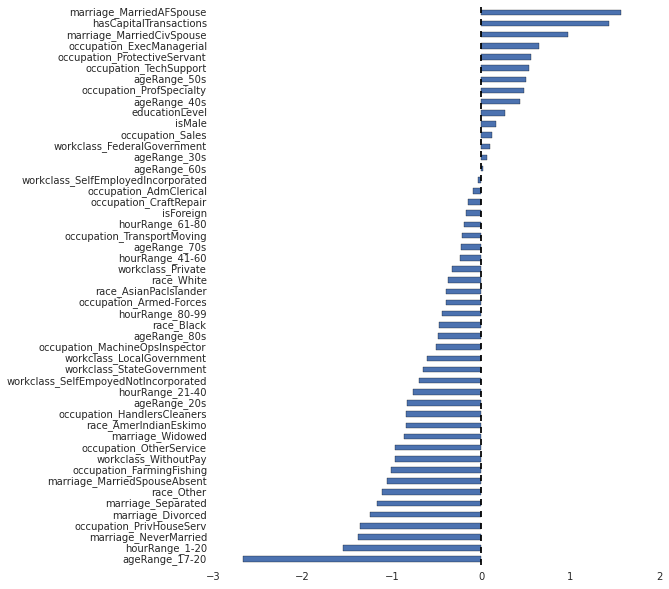

In [40]:
# now let's make a pandas Series with the names and values, and plot them
%matplotlib inline

weights = pd.Series(LRTask1.coef_[0],index=df1.columns)
weights = weights.order(ascending=True)
weights.plot(kind='barh',figsize=(8,10))

As we can see from the bar chart above, the attributes that are most related to **making more than 50K a year** are:
* Being married to someone from the Armed Forces
* Being married to a civilian
* Having capital transactions

These make sense, especially capital transactions because if people that have enough money to be investing in stock, real state, etc, probably have a salary higher than 50K.
Being married to a civilian or someone from the Armed Forces also shows that a typical married life might make it easy to grow professionally and increase your salary.

On the opposite end of the bar chart, the inversely related attributes are:
* Being 17 to 20 years old
* Working between 1 and 20 hours a week (part-time)
* Never being Married

The age is fairly obvious, because someone under 20 years old is unlikely to make more than 50K a year.
Also, someone who works less than 20 hours a week is not likely to make a lot of money, this are probably students and part time workers.
The interesting one is never being married, which seems to inversely affect your chances of making a high salary.

#### Random Forests

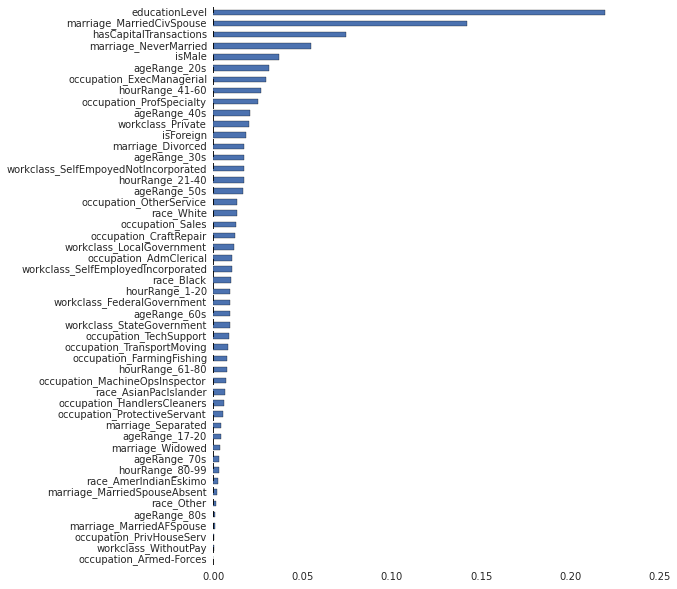

In [61]:
# now let's make a pandas Series with the names and values, and plot them
%matplotlib inline

weights = pd.Series(RFTask1.feature_importances_,index=df1.columns)
weights = weights.order(ascending=True)
weights.plot(kind='barh',figsize=(8,10))

#### Random Forests

ADD SOME EXPLANATION HERE!

#### Classification Task 2
Predict if a person makes capital trades, based on their age, race, sex, etc. (all of the attributes)

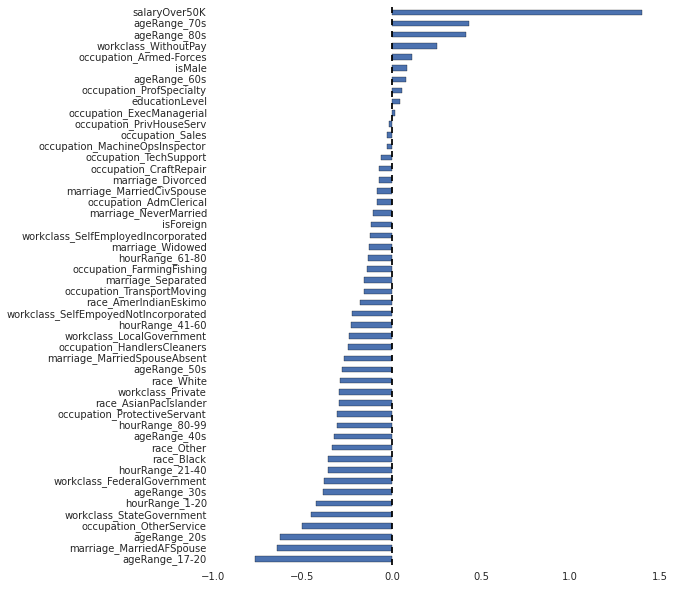

In [38]:
# sort these attributes and spit them out
zip_vars = zip(LRTask2.coef_.T,df2.columns)
zip_vars.sort(key = lambda t: np.abs(t[0]))

# now let's make a pandas Series with the names and values, and plot them
%matplotlib inline

weights = pd.Series(LRTask2.coef_[0],index=df2.columns)
weights = weights.order(ascending=True)
weights.plot(kind='barh',figsize=(8,10))

As we can see from the bar chart above, the attributes that are most related to **having capital trades are**:
* Having a salary over 50K
* Being in your 60s
* Education level

Similarly to our previous classification task, a salary larger than 50K is closely related to making investments and/or capital transactions. This is probably because of the sparse income that can be risked in an easier way.
Apparently people on their 60s tend to make a lot of capital trades, and also the education level is directly related.

On the opposite end of the bar chart, the inversely related attributes are:
* Originating from Scotland, Thailand or the Outlying US
* Having other service as occupation
* Being 17 to 20 years old

The age is fairly obvious, because someone under 20 years old is unlikely to make capital trades.
The other two are more ambiguous predictions.

---
### 5. Results Analysis with Evaluation Metrics (10 points)
**Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis.**



#### Task 1 Classification Model Performance
The following graph demonstrates the success of each model for classification task 1.

In [ ]:
# Graph of different classification models for task 1
fig = plt.figure(figsize=(12, 4))
chart = fig.add_subplot(111)

chart.set_xlabel('Model')
chart.set_ylabel('Accuracy')
chart.set_title('Classification Model Performance (Task 1)')

numMetrics = np.arange(4)
bar_width = 0.2

rects1 = chart.bar(numMetrics, task1Values[0], bar_width,
                 color='b',
                 label='Accuracy')

rects2 = chart.bar(numMetrics + bar_width, task1Values[1], bar_width,
                 color='g',
                 label='Recall')

rects3 = chart.bar(numMetrics + bar_width*2, task1Values[2], bar_width,
                 color='y',
                 label='Precision')

rects4 = chart.bar(numMetrics + bar_width*3, task1Values[3], bar_width,
                 color='r',
                 label='F-Measure')

tickMarks = chart.set_xticks(numMetrics + bar_width*2)

labels = ('Logistic Regression', 'K-Nearest Neighbors', 'Random Forrests', 'Naive-Bayes')
tickLabels = chart.set_xticklabels(labels)


chart.legend()

plt.tight_layout()
plt.show()

For classification task 1, Logistic Regression, K-Nearest Neighbors, and Random Forrests all performed similarly. These algorithms produced models that had a high degree of accuracy, and a relitively high degree of Precision, F-Measure, and Recall. Naive-Bayes was unique as it's recall was <i>very</i> high, however, it's accuracy and precision were significantly lower than the other models.



#### Task 2 Classification Model Performance
The following graph demonstrates the success of each model for classification task 2.

In [ ]:
# Graph of different classification models for task 2
fig = plt.figure(figsize=(12, 4))
chart = fig.add_subplot(111)

chart.set_xlabel('Model')
chart.set_ylabel('Accuracy')
chart.set_title('Classification Model Performance (Task 2)')

numMetrics = np.arange(4)
bar_width = 0.2

rects1 = chart.bar(numMetrics, task2Values[0], bar_width,
                 color='b',
                 label='Percentage')

rects2 = chart.bar(numMetrics + bar_width, task2Values[1], bar_width,
                 color='g',
                 label='Recall')

rects3 = chart.bar(numMetrics + bar_width*2, task2Values[2], bar_width,
                 color='y',
                 label='Precision')

rects4 = chart.bar(numMetrics + bar_width*3, task2Values[3], bar_width,
                 color='r',
                 label='F-Measure')

tickMarks = chart.set_xticks(numMetrics + bar_width*2)

labels = ('Logistic Regression', 'K-Nearest Neighbors', 'Random Forrests', 'Naive-Bayes')
tickLabels = chart.set_xticklabels(labels)


chart.legend()

plt.tight_layout()
plt.show()

Similar to classification task 1, Logistic Regression, K-Nearest Neighbors, and Random Forrests for classification task 2 also had a high degree of consistency. These algorithms produced models that had a <i>very</i> high degree of accuracy, and a relatively high degree of Precision. Unlike classification task 1, these algorithms did, however, perform very poorly in terms of recall and F-Measure. Naive-Bayes was also unique for classification task 2; as with classification task 1, it produced a fairly high recall value with an accuracy value close behind. Precision and F-Measure were significantly lower for Naive-Bayes than for the other models.



#### Average Classification Model Performance
The following graph demonstrates how each algorithm performed overall for both task 1 and task 2.

In [ ]:
# Graph of different classification models for both tasks (average)
fig = plt.figure(figsize=(12, 4))
chart = fig.add_subplot(111)

chart.set_xlabel('Model')
chart.set_ylabel('Percentage')
chart.set_title('Classification Model Performance (Average)')

numMetrics = np.arange(4)
bar_width = 0.2

finalAcc = [(x + y)/2 for x, y in zip(task1Values[0], task2Values[0])]
finalRecall = [(x + y)/2 for x, y in zip(task1Values[1], task2Values[1])]
finalPrecision = [(x + y)/2 for x, y in zip(task1Values[2], task2Values[2])]
finalFMeasure = [(x + y)/2 for x, y in zip(task1Values[3], task2Values[3])]

rects1 = chart.bar(numMetrics, finalAcc, bar_width,
                 color='b',
                 label='Accuracy')

rects2 = chart.bar(numMetrics + bar_width, finalRecall, bar_width,
                 color='g',
                 label='Recall')

rects3 = chart.bar(numMetrics + bar_width*2, finalPrecision, bar_width,
                 color='y',
                 label='Precision')

rects4 = chart.bar(numMetrics + bar_width*3, finalFMeasure, bar_width,
                 color='r',
                 label='F-Measure')

tickMarks = chart.set_xticks(numMetrics + bar_width*2)

labels = ('Logistic Regression', 'K-Nearest Neighbors', 'Random Forrests', 'Naive-Bayes')
tickLabels = chart.set_xticklabels(labels)


chart.legend()

plt.tight_layout()
plt.show()

This graph indicates the average performance of each algorithm for both of the classification tasks. Overall, each algorithm performed very well. Some produced a higher degree of accuracy and precision while others produced a higher degree of recall. In the future, these results will allow us to custom taylor models for specific real-world applications (i.e., we can choose to utilize Naive-Bayes if we want to have a low degree of false negatives).

Across both classification tasks and all four models, the majority of the analysis metrics were reasonably consistent. The exception to this being the recall values produced by the Naive-Bayes algorithm.



#### Task 2 Classification Model Performance
The following graph demonstrates the success of each model for classification task 2.

In [ ]:
# Graph of classification task performance (using metrics to indicate model overall task performance)
fig = plt.figure(figsize=(12, 4))

plt.xlabel('Analysis Metric')
plt.ylabel('Percentage')
plt.title('Classification Task Performance')
numMetrics = np.arange(4)
bar_width = 0.35

task1 = (task1Acc, task1Recall, task1Precision, task1FMeasure)
task2 = (task2Acc, task2Recall, task2Precision, task2FMeasure)

rects1 = plt.bar(numMetrics, task1, bar_width,
                 color='b',
                 label='Task 1')

rects2 = plt.bar(numMetrics + bar_width, task2, bar_width,
                 color='g',
                 label='Task 2')


plt.xticks(numMetrics + bar_width, ('Accuracy', 'Recall', 'Precision', 'F-Measure'))
plt.legend()
plt.tight_layout()
plt.show()

Finally, this graph indicates the overall performance of all four models for each of the classification tasks, broken down my individual analysis metrics. The key takeaway from this graph is that Task 1 out-performed task 2 on three of the four key metrics. Overall, this the models we created for this task have the most potential.

---
### 6. Model Advantages (10 points)
**Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods.**

####Classification Task 1:
As stated in the section above, Logistic Regression, K-Nearest Neighbors, and Random Forrests all generated very consistent results in terms of accuracy, recall, precision, and F-Measure. Naive-Bayes, however, was significantly different on all accounts. Three of the four metrics of this model were inferior to that of the other 3 models, however, the recall value for Naive-Bayes was significantly higher (a difference of more than 30%). Because of the importance associated with minimizing the number of false negatives (discussed in the <strong>Evaluation Metrics</strong> section, this model may be a promising choice for classification task 1. That being said, there is not any one model that stands out as being better than the others; each of the models performs very well overall.

####Classification Task 2:
The results generated by the models we created for this task had some interesting results. While the results of classification task 1 were relatively consistent, certain metrics measuring task 2's performance were quite varied. Accuracy was consistent across all the models, with Naive-Bayes being slightly lower than the others, however, Precision and F-Measure vary across all four models and recall values for all models <i>except</i> Naive-Bayes are virtually insignificant.

While classification task 1 resulted in four equally valid models, the results of task 2's classification resulted in 2 key models: Logistic Regression and Naive-Bayes. Depending on the cost of misclassification and the cost of false negatives/positives, one may be better than the other for a specific sitation. For the purpose of this assignment, we chose to minimize false negatives and due to the significant difference between the recall of Logistic Regression and Naive-Bayes (nearly a 70% difference), Naive-Bayes is likely the best choice of classification model.

####Statistical Significance:
In terms of confidence, because we trained all models for both classification tasks against the same data (and the same number of instances) any difference over 5% in terms of accuracy, recall, precision, or F-Measure is statistically significant with 95% confidence.

Evaluation and Deployment
---

---
### 1. Model Evaluation (5 points)
**Build on and update your dicussion from last assignment: How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used? How would your deploy your model for interested parites? What other data should be collected? How often would the model need to be updated, etc.?**

As we discussed last time, our primary classification model (salary > \$50k) has serious potential for real-world applications. While it can be difficult to obtain informormation about consumer income level, it can be an incredibly useful piece of information once obtained. Given the necessary demographic information, our model can predict whether or not it is likely that an individual makes a salary of over $50k. Overall, our 4 classification models had an average accuracy of nearly 80% with Recall, Precision, and F-Measure values of over 60%. These metrics indicate that each of our models perform very well, especially given the low cost associated with misclassification.

As we stated in our previous analysis, these classification models could be used (assuming the business had access to the necessary demographic information) to help predict wether or not a specific individual would be interested in purchasing a luxury product or service, or at minimum, whether the person could actually afford this product or service. In order to measure the the value of these models, we could evaluate the conversion rate from targeted sales efforts that use the information they generate. If the models identifie a certain portion of the population that is likely to make over $50k, targeted advertisements could be made to those individuals. The rate of which those ads lead to sales could be used as an indicator for the overall value of the models.

Deploying these models would require a decent amount of data regarding the individual(s) being targeted. Once this data was obtained, it would be very simple to identify the which members of the population are estimated to make a salary of $50k or more and advertisements could then be made to these individuals. After advertisements have reached their targets, data should be recorded as to whether or not the individual purchased the product or service. This data could eventually be used to form a new model which further predicts whether an individual would be interested in a specific product or service as opposed to a category of products or services.

The models for our secondary classification task (whether or not an individual makes capital trades) could be very useful to the IRS. Given the necessary demographic information, the IRS could use the models we have created to isolate a group of individuals that may be more likely to evade their taxes, specifically individuals who do not fully report capital gains.

To evaluate this model, the IRS could use data generated from the model and compare the percentage of audits that resulted in additional fines for this group against the same percentage generated from traditional methods. If the data generated by our model results in a higher percent of audits that lead to fines, our model will have a positive impact.

In regards to updating the models for classification tasks 1 and 2, at minimum, the models should be updated every time new census data becomes availible (every 10 years). If an adequate amount of data could be obtained before new census data becomes available, it would be beneficial to further train our models to help compensate for societal changes as well as inflations impact upon salary. In addition, if the IRS were to include information about previous tax evasions along with the with demographic information, the model could be further trained to predict tax evasions as a whole.

Exceptional Work (10 points)
---

---
**You have free reign to provide additional modeling.**

We did 4 classification models for each classification task, and we also measured the four metrics for each of their combinations, which counts for additional modeling and exceptional work. :D

and

Happy Easter!


In [ ]:
      __            /^\
    .'  \          / :.\   
   /     \         | :: \ 
  /   /.  \       / ::: | 
 |    |::. \     / :::'/  
 |   / \::. |   / :::'/
 `--`   \'  `~~~ ':'/`
         /         (    
        /   0 _ 0   \   
      \/     \_/     \/  
    -== '.'   |   '.' ==-   
      /\    '-^-'    /\    
        \   _   _   /             
       .-`-((\o/))-`-.   
  _   /     //^\\     \   _    
."o".(    , .:::. ,    )."o".  
|o  o\\    \:::::/    //o  o| 
 \    \\   |:::::|   //    /   
  \    \\__/:::::\__//    /   
   \ .:.\  `':::'`  /.:. /      
    \':: |_       _| ::'/  
     `---` `"""""` `---`

### Old Stuff below this Line
---

---
### 2. Model Advantages (5 points)
**Discuss the advantages of each model for each classification task.**

For each of the classification tasks, both models are very accurate, with over 75% accuracy for the least accurate model.

The advantage of the Logistic Regression model is that it is much faster to run than the Support Vector Machine and gives a comparable accuracy.

In our computers the logistic regresion took at most 2 seconds, whereas the SVM took at least 30 seconds.

---
### 3. Logistic Regression Features (15 points)
**Use the weights from logistic regression to interpret the importance of different features for each classification task. Explain your interpretation.**

#### Classification Task 1
Predict if a person makes more than 50, 000 dollars a year, based on their age, race, sex, etc. (all of the attributes)

In [ ]:
# sort these attributes and spit them out
zip_vars = zip(LRTask1.coef_.T,df1.columns)
zip_vars.sort(key = lambda t: np.abs(t[0]))
for coef, name in reversed(zip_vars):
    print name, 'has importance of', coef[0]

In [ ]:
# now let's make a pandas Series with the names and values, and plot them
%matplotlib inline

weights = pd.Series(LRTask1.coef_[0],index=df1.columns)
weights = weights.order(ascending=True)
weights.plot(kind='barh',figsize=(8,20))

As we can see from the bar chart above, the attributes that are most related to **making more than 50K a year** are:
* The Education Level
* Being Married to a civilian
* Having capital transactions

These make sense, especially capital transactions because if people that have enough money to be investing in stock, real state, etc, probably have a salary higher than 50K.
Being married to a civilian (the other choice was married to someone from the air force) also shows that a typical married life might make it easy to grow professionally and increase your salary.
Lastly, the education level, is directly related, simply because the higher the education level is, the more people will pay for your work.

On the opposite end of the bar chart, the inversely related attributes are:
* Being 17 to 20 years old
* Never being Married
* Having other service as occupation

The age is fairly obvious, because someone under 20 years old is unlikely to make more than 50K a year.
The interesting one is never being married, which seems to inversely affect your chances of making a high salary.
Finally, for the occupation as "other service", it probably refers to the service industry or jobs as such.

#### Classification Task 2
Predict if a person makes capital trades, based on their age, race, sex, etc. (all of the attributes)

In [ ]:
# sort these attributes and spit them out
zip_vars = zip(LRTask2.coef_.T,df2.columns)
zip_vars.sort(key = lambda t: np.abs(t[0]))
for coef, name in reversed(zip_vars):
    print name, 'has importance of', coef[0]

In [ ]:
# now let's make a pandas Series with the names and values, and plot them
%matplotlib inline

weights = pd.Series(LRTask2.coef_[0],index=df2.columns)
weights = weights.order(ascending=True)
weights.plot(kind='barh',figsize=(8,20))

As we can see from the bar chart above, the attributes that are most related to **having capital trades are**:
* Having a salary over 50K
* Being in your 60s
* Education level

Similarly to our previous classification task, a salary larger than 50K is closely related to making investments and/or capital transactions. This is probably because of the sparse income that can be risked in an easier way.
Apparently people on their 60s tend to make a lot of capital trades, and also the education level is directly related.

On the opposite end of the bar chart, the inversely related attributes are:
* Originating from Scotland, Thailand or the Outlying US
* Having other service as occupation
* Being 17 to 20 years old

The age is fairly obvious, because someone under 20 years old is unlikely to make capital trades.
The other two are more ambiguous predictions.

#### Classification Task 3
Predict if a person is male, based on their age, race, sex, etc. (all of the attributes)

In [ ]:
# sort these attributes and spit them out
zip_vars = zip(LRTask3.coef_.T,df3.columns)
zip_vars.sort(key = lambda t: np.abs(t[0]))
for coef, name in reversed(zip_vars):
    print name, 'has importance of', coef[0]

In [ ]:
# now let's make a pandas Series with the names and values, and plot them
%matplotlib inline

weights = pd.Series(LRTask3.coef_[0],index=df3.columns)
weights = weights.order(ascending=True)
weights.plot(kind='barh',figsize=(8,20))

As we can see from the bar chart above, the attributes that are most related to **being a male** are:
* Occupation in craft/repairs, transport/moving, handlers/cleaners and fishing/farming
* Being married to a civilian
* Working from 41-60 hours a week

We can see that those occupations are mostly associated with males, but being married and working 41-60 hours a week are hard to see the relationship.

On the opposite end of the bar chart, the inversely related attributes are:
* Being widowed or divorced or separated
* Occupation in Adm Clerical, Prof Specialty, Private Hous Service
* Working from 1-20 hours

Considering that this census is from 1994, these predictions seem to be based on the traditional household, where woman stayed at home or wokred part time.
It is interesting to see how being widowed, divorced or separated is mostly associated with women in this data set.

---
### 4. SVM Support Vectors (15 points)
**Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain.**

#### Classification Task 1
Predict if a person makes more than 50, 000 dollars a year, based on their age, race, sex, etc. (all of the attributes)

In [ ]:
# look at the support vectors
print svm_clf1.support_vectors_.shape
print svm_clf1.support_.shape
print svm_clf1.n_support_ 

In [ ]:
# These are the support vectors of our classification task 1
weights = pd.Series(svm_clf1.coef_[0],index=df1.columns)
weights = weights.order(ascending=True)
weights.plot(kind='barh',figsize=(8,20))

The chart above indicates a variety of attributes that are either positively or negatively correlated with whether or not an individual has a salaray of **more than $50K**:
* Education level (highly positive correlation)
* Being married to a civilian spouse (highly positive correlation)
* Making capital transactions (either making gains or losses, both positive correlations)
* Having never been married before or remaining single after a divorce (both negative correlations)
* Being between the age of 17-20 (negative correlation)

These results are very understandable. It would be expected that someone who has a high education level, is married to a civilian spouse, and/or makes capital transactions would make a yearly salary of $50K or greater.

It is also not surprising that being young (17-20) or being single (either never married or single after a divorce) is correlated with having a salary of less than $50k per year.

#### Classification Task 2
Predict if a person makes capital trades, based on their age, race, sex, etc. (all of the attributes)

In [ ]:
# look at the support vectors
print svm_clf2.support_vectors_.shape
print svm_clf2.support_.shape
print svm_clf2.n_support_ 

In [ ]:
# These are the support vectors of our classification task 2
weights = pd.Series(svm_clf2.coef_[0],index=df2.columns)
weights = weights.order(ascending=True)
weights.plot(kind='barh',figsize=(8,20))

The chart above indicates that there are several attributes which are highly correlated with **making capital transactions** are:
* Occupation as administration or clerical positions (negative correlation)
* Race of Asian/Pacific Islander (negative correlation)
* Hour Range (Either between 41-60 [negative correlation] or between 1 and 20 [positive correlation])
* US Origin (positive correlation)

These results are somewhat surprising, however, the origin and racial considerations may be rooted in cultural norms and life outlooks. The correlation between hours worked (1-20) and making capital transactions is somewhat surprising as many would imagine this correlation would be negative, however, it is positive in the context of our training set. Gathering additional information or additional instances of data may alter this attributes affect on the target.

#### Classification Task 3
Predict if a person is male, based on their age, race, sex, etc. (all of the attributes)

In [ ]:
# look at the support vectors
print svm_clf3.support_vectors_.shape
print svm_clf3.support_.shape
print svm_clf3.n_support_ 

In [ ]:
# These are the support vectors of our classification task 3
weights = pd.Series(svm_clf3.coef_[0],index=df3.columns)
weights = weights.order(ascending=True)
weights.plot(kind='barh',figsize=(8,20))

Finally, this chart indicates that there are several attributes present in the model for classification task 3 which are highly correlated with whether or not an individual is **male**:
* Being married to a civilian spouse (highly positive correlation)
* Having an occupation as a Craftsman or Repairman (highly positive correlation)
* Being self employed (positive correlation)
* Having never been married before or remaining single after a divorce (both negative correlations)

These results fall in line with expectations. The occupations discussed above would more than likely be dominantly male, being self employed would seem to be correlated with being male in the US, and finally, it is not surprising that males are also more likely to never become married or to remain single after becoming divorced.

---
### 4. Model Performace (5 points)
**Assess how well each model performs (use training/test data as appropriate)**

In [ ]:
# For each model, we used the same training/testing sizes:
# TRAINING: 80% of the data set
# TESTING: 20% of the data set

In [ ]:
print "MODEL 1 PERFORMANCE:"
print("Logistic Regression: %.2f" % (modelOneReg*100))+"%"
print("SVM: %.2f" % (modelOneSVM*100))+"%"+"\n"

In [ ]:
print "MODEL 2 PERFORMANCE:"
print("Logistic Regression: %.2f" % (modelTwoReg*100))+"%"
print("SVM: %.2f" % (modelTwoSVM*100))+"%"+"\n"

In [ ]:
print "MODEL 3 PERFORMANCE:"
print("Logistic Regression: %.2f" % (modelThreeReg*100))+"%"
print("SVM: %.2f" % (modelThreeSVM*100))+"%"+"\n"

As we can see from these numbers, both models perform excedingly well.
We highly prefer logistic regression because it runs extremely fast and produces very accurate predictions.

Exceptional Work (10 points)
---

---
### 1. Model Evaluation (5 points)
**You have free reign to provide additional modeling. One idea: fuse the outputs of the two classifiers to create a new classifier or use grid searching to estimate parameters of the models.**

We did 3 classification tasks, instead of only 2, which counts for additional modeling and exceptional work. :D